# ml sepsis logistic regression model


## Update: 25Nov21

- New test dataset obtained 'perth data set'. The samples in this data were collected in Perth Australia and sequenced using a different technology (RNAseq) to the first dataset from Edinburgh (uses microarray sequencing).
- The data contains 78 examples: 13 confirmed sepsis, 55 control/healthy. 
- Data normalisation - spent a week understanding how this data is generated, what the raw data means, and how the normalisation works. Worked closely with Robert Andrews (bioinformatician) to understand and tweak the R code that pre-processes the data. This was time consuming, but essential to know what I'm looking at.
- Gene code mapping - given the different sequencing technologies, the 'probes' that map to genes have to be mapped between the data sets. Have spent time understanding how to download the mappings (from a database called biomart) and create the mapping. I haven't been able to map all genes- 3 out of 21 selected by logistic regression model excluded.

- Model testing - trained a logistic regression model without any penalty on the origina edinburgh dataset, using only 18 features - those selected by the LASSO, then tested the model on the test dataset.

- The results on the new test set are not good: AUC: 0.75 / Recall: 0.69 / Specificity: 0.65

- Looking at the raw z-scores for the genes selected by the original model, they do not appear to be discriminative for the new data - compare this image with the separation that we saw on the training data for these genes.


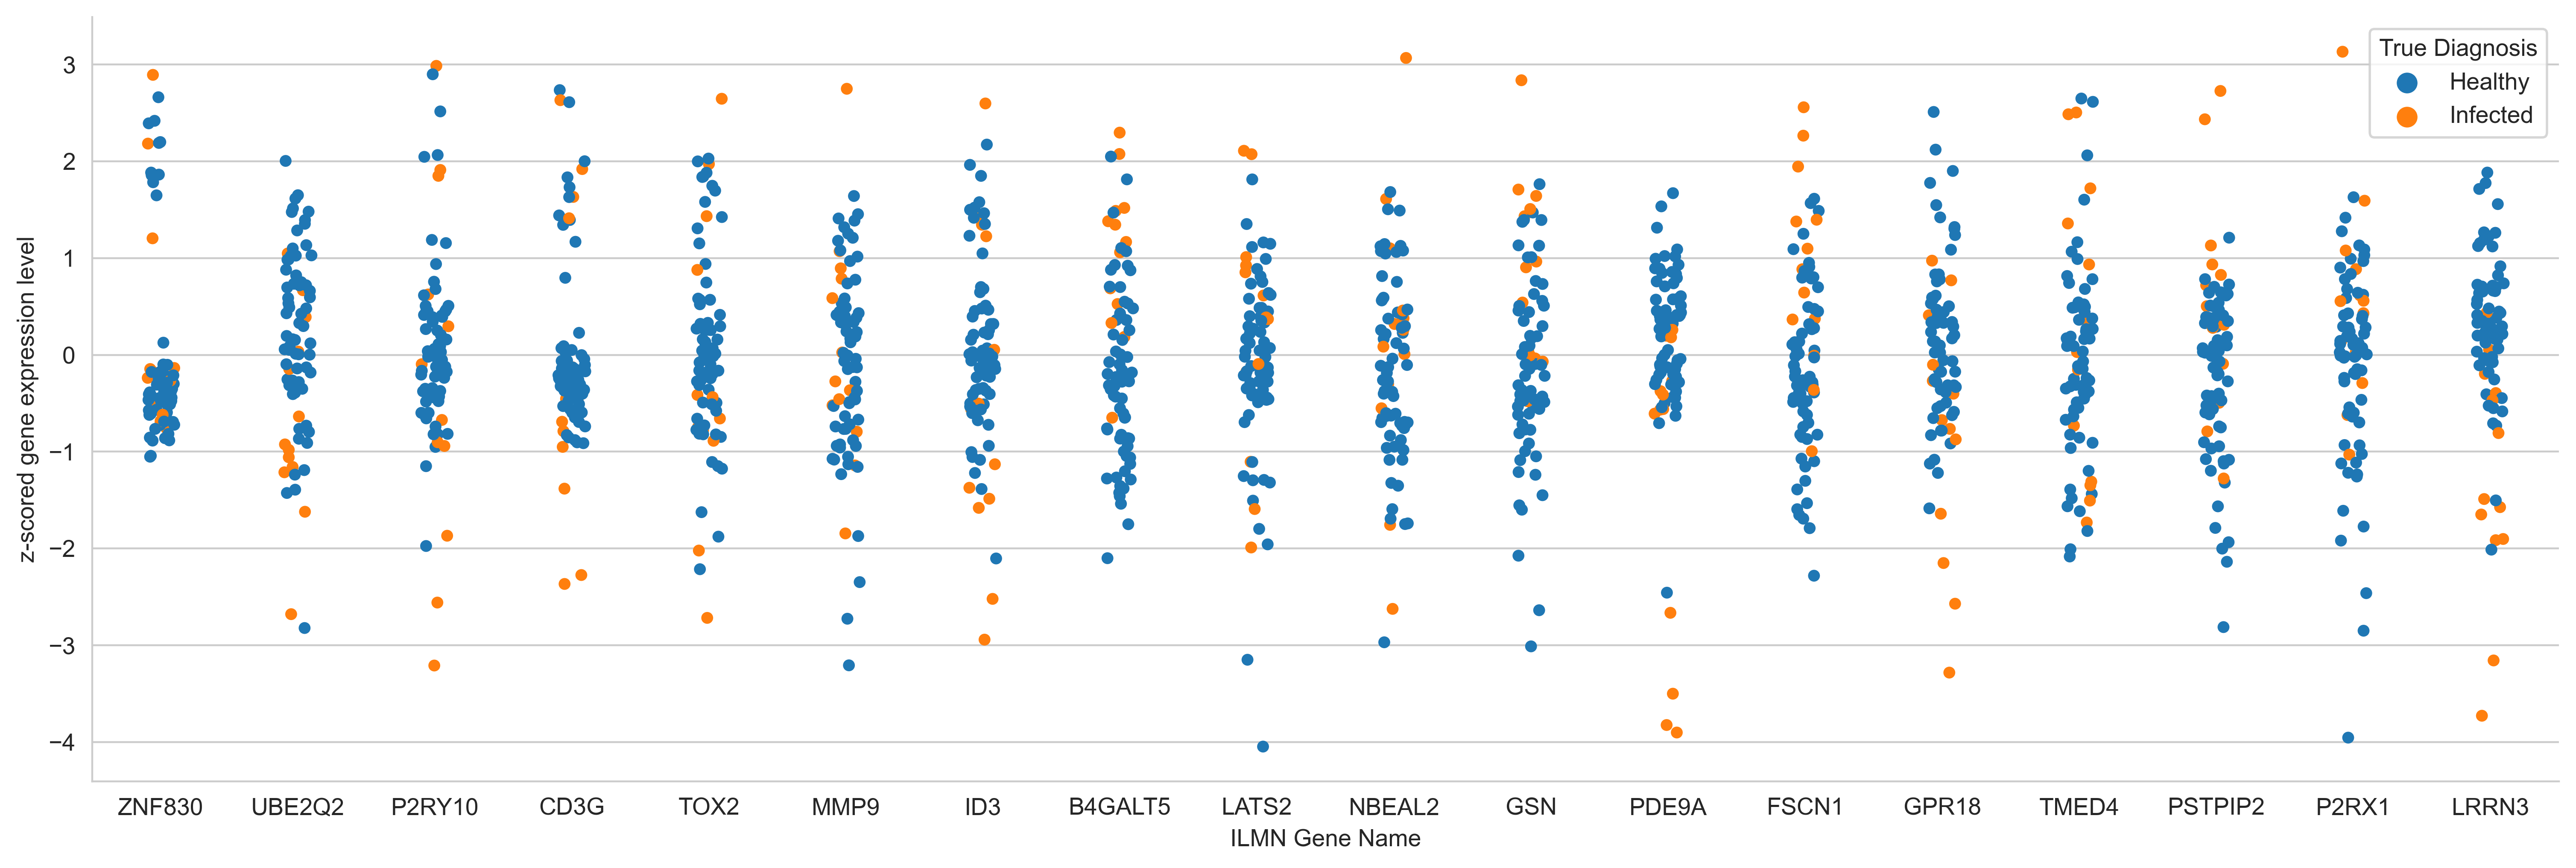


## Potential Next Steps

- Complete and check again the mapping of the genes to make sure that there is no issue with the correspondence of the genes between the two feature sets.
- Repeat the training analysis on this new dataset and look at which genes selected - is there any overlap with previous models (e.g. SVM, Random Forest)
- Source additional publicy available datasets for testing.
- Consider combining multiple datasets into a combined training set to expand the amount of training data available. Maybe 63 examples is just too small to derive meaningful results / feature selection
- Investigate data augmentation - not started yet
- Iteratively test small subsets of genes - 1s, 2s, 3s, 4s - look for statistically significant improvements. Use Leave One Out cross validation given small size of the data set.

In [261]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import KFold, RepeatedKFold
import warnings
import pickle
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.")
#np.random.seed(1)


In [262]:
os.getcwd()

'/Users/Ed/Documents/GitHub/sepsis_ml_omics_msc'

### Preprocessed Data Import

In [351]:
# retriving saved results:

with open('neonatal_preprocessed.pkl', 'rb') as f:
    gene_df, X_df, X_df_no75, X_df_red, labels, labels_no75 = pickle.load(f)
    
X_df_no75 = pd.read_csv('neonatal_data_processed.csv', index_col=0)
labels_no75 = np.loadtxt('labels_no75.csv', delimiter=',')
gene_df = pd.read_csv('gene_codes_df.csv', index_col=0)

### Functions for model analysis

In [263]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

# Code credit for thresholds with Youdens: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# Code credit for ROC curve: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

def j_stat(y_true_classes, y_pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_probabilities)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    return best_thresh

def score_model(y_true_classes, y_pred_probabilities, threshold):
    y_pred_classes = []
    for probab in y_pred_probabilities:
        if probab >= threshold:
            y_pred_classes.append(1)
        else:
            y_pred_classes.append(0)
    tn, fp, fn, tp = confusion_matrix(y_true_classes, y_pred_classes).ravel()
    accuracy = round((tp + tn / (tn+fp+fn+tp)),2)
    recall = round((tp / (tp+fn)),2)
    specificity = round((tn / (tn+fp)),2)
    precision = round((tp / (tp+fp)),2)
    auc = round(roc_auc_score(y_true_classes, y_pred_probabilities),2)
    return y_pred_classes, accuracy, recall, specificity, precision, auc

def mis_class_points(X_test, y_true_classes, y_pred_classes):
    mis_classified = {}
    for row_index, (examples, prediction, label) in enumerate(zip (X_test, y_pred_classes, y_true_classes)):
        if prediction == label:
            continue
        if prediction == 0 and label == 1:
            mis_classified[X_test.iloc[[row_index]].index[0]] = 'fn'
        elif prediction == 1 and label == 0:
            mis_classified[X_test.iloc[[row_index]].index[0]] = 'fp'
    return mis_classified  

def plot_cm(y_true_classes, y_pred_classes):
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot(colorbar=False)

def build_roc_auc(y_true_classes, y_pred_probabilities):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_true_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_classes, y_pred_probabilities)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_classes, y_pred_probabilities)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic plot')
    plt.show()
    
    return roc_auc_score(y_true_classes, y_pred_probabilities)  


In [264]:
from sklearn.model_selection import RepeatedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
import skopt
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_evaluations
from math import log
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before")

### ii. LR - Optimise for a fixed number of features

In [265]:
# redesigned functions to achieve the following:

# hyper parameter tuning and feature selection within the inner loop
# retraining of a new model without L1 penalisation using selected features only - score this model
# train final model on full dataset to get features

def train_lr_loocv(X_train, y_train, n_features):

    # define cross validation approach
    cv_inner = LeaveOneOut()
    
    # collectors for predictions
    val_examples = []
    y_val_classes = []
    y_val_predictions = []
    features_index_list = []
    
    # training and validation set split
    for train_index, val_index in cv_inner.split(X_train):

        X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        y_train_inner, y_val = y_train[train_index], y_train[val_index] 

        # define hyper paramaeter search space
        hyper_p_c = Real(low=1e-6, high=1000.0, prior='log-uniform', name='C')
        search_space_lr = [hyper_p_c]

        # baysian search for hyper parameter that gives n_features
        @use_named_args(search_space_lr)
        def evaluate_model(**params):
        
            model = LogisticRegression(penalty='l1', solver="liblinear")
            model.set_params(**params)
            model.fit(X_train_inner, y_train_inner)
            n_nonzero = np.sum(model.coef_ != 0)
            
            return (n_features-n_nonzero)**2

        result = gp_minimize(evaluate_model, search_space_lr, acq_func="EI", x0=[1.0], n_initial_points=20, n_calls=30)
        best_parameter = result.x
        print('Best Parameter: %s' % (result.x))
        
        # train new model with this value of C, using L1 penalty, and capture selected features
        model = LogisticRegression(C=best_parameter[0], penalty='l1', solver="liblinear")
        model.fit(X_train_inner, y_train_inner)
        selected_index = np.nonzero(model.coef_[0])[0]
        features_index_list.append(selected_index)

        print("The number of features selected is:   "+str(np.sum(model.coef_ != 0)))
        print("The index of selected features is:    :"+str(selected_index))
        
        # reduce the dataset to the selected features only
        X_train_selected = np.take(X_train_inner, selected_index, axis=1)
        X_val_selected = np.take(X_val, selected_index, axis=1)
        
        # train a model on the selected features only
        model = LogisticRegression(C=best_parameter[0], penalty='none', solver="lbfgs")
        model.fit(X_train_selected, y_train_inner)
        
        # make predictions on the validation set and save to collectors
        val_examples.append(X_val_selected)
        y_val_classes.append(y_val)
        y_val_pred_probab = model.predict_proba(X_val_selected)
        y_val_predictions.append(y_val_pred_probab[0,1])
            
    # return classes and predictions
    return y_val_classes, y_val_predictions, features_index_list


def train_lr_final(X_train, y_train, n_features):

    # define hyper paramaeter search space
    hyper_p_c = Real(low=1e-6, high=1000.0, prior='log-uniform', name='C')
    search_space_lr = [hyper_p_c]

    # baysian search for hyper parameter that gives n_features
    @use_named_args(search_space_lr)
    def evaluate_model(**params):

        model = LogisticRegression(penalty='l1', solver="liblinear")
        model.set_params(**params)
        model.fit(X_train, y_train)
        n_nonzero = np.sum(model.coef_ != 0)

        return (n_features-n_nonzero)**2

    result = gp_minimize(evaluate_model, search_space_lr, acq_func="EI", x0=[1.0], n_initial_points=20, n_calls=40)
    best_parameter = result.x
    print('Best Parameter: %s' % (result.x))

    # train new model with this value of C, using L1 penalty, and capture selected features
    final_model = LogisticRegression(C=best_parameter[0], penalty='l1', solver="liblinear")
    final_model.fit(X_train, y_train)
    selected_index = np.nonzero(final_model.coef_[0])[0]
    print("The number of features selected is:   "+str(np.sum(final_model.coef_ != 0)))
    print("The index of selected features is:    "+str(selected_index))
        
    return final_model, selected_index, best_parameter


In [266]:
#test_y_val_classes, test_y_val_predictions, test_features_index_list = train_lr_loocv(X_df_red, labels, 20)


In [267]:
y_val_classes, y_val_predictions, features_index_list = train_lr_loocv(X_df_no75, labels_no75, 20)


Best Parameter: [0.060286820324701784]
The number of features selected is:   9
The index of selected features is:    :[ 1198 10360 11732 20606 23050 32422 33118 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10561127935728869]
The number of features selected is:   19
The index of selected features is:    :[ 1198  3448  9424 10360 11732 12281 13543 13609 13839 20606 23050 30200
 32422 33118 39675 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.13738010862552888]
The number of features selected is:   26
The index of selected features is:    :[ 1198  3448  4293  6416  9424 10360 11732 13609 13839 14608 15742 17243
 20606 23050 30200 31054 32422 33118 35139 39675 44725 44775 45685 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.12454634087967076]
The number of features selected is:   26
The index of selected features is:    :[ 1198  3448  5734 10360 11732 12281 13609 14587 14902 17243 18178 20606
 22168 23050 30200 32422 33118 34213 36715 39675 40296 44725 45685 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.09415653586977557]
The number of features selected is:   19
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13609 13839 14608 20606 22168 23050 30200
 32422 33118 40296 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.0986741958399632]
The number of features selected is:   17
The index of selected features is:    :[ 1198 10360 11732 12281 13839 20606 23050 27907 30200 32422 33118 39675
 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.07890375600736582]
The number of features selected is:   13
The index of selected features is:    :[ 1198  5734 10360 11732 12152 13839 20606 23050 32422 33118 40296 47653
 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.13481898225806047]
The number of features selected is:   27
The index of selected features is:    :[ 1198  3448  4293 10360 11732 12152 12281 13609 13839 14608 14902 20606
 22168 23050 28488 30200 32422 33118 36715 37377 39675 40296 43481 45685
 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.09210762842633535]
The number of features selected is:   15
The index of selected features is:    :[ 1198 10360 11732 12281 13839 17243 20606 23050 30200 32422 33118 40296
 44725 45685 47653]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.13914583448509776]
The number of features selected is:   20
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13839 14608 14902 20606 23050 30200 32422
 33118 36715 39675 40296 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10833097804152769]
The number of features selected is:   14
The index of selected features is:    :[ 1198 10360 11732 13609 13839 20606 23050 30200 32422 33118 45685 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10673326457654281]
The number of features selected is:   17
The index of selected features is:    :[ 1198  3448 10360 11732 12152 12281 13839 20606 23050 30200 32422 33118
 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.0973009454408378]
The number of features selected is:   17
The index of selected features is:    :[ 1198 10360 11732 12281 13609 13839 14608 20606 23050 24824 30200 32422
 33118 40296 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10680877279445856]
The number of features selected is:   16
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13839 20606 23050 30200 32422 33118
 39675 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.18610239913139626]
The number of features selected is:   34
The index of selected features is:    :[ 1198  3448  4293  5539  5996  8331 10360 11732 12281 13543 13646 13839
 14608 14902 17472 20606 22168 23050 28488 30200 31996 33118 34813 35139
 36715 37377 37986 44670 44725 45597 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.0845255780855981]
The number of features selected is:   14
The index of selected features is:    :[ 1198 10360 11732 12281 20606 23050 24824 32422 33118 40296 45685 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.1347428996860722]
The number of features selected is:   26
The index of selected features is:    :[ 1198  3170  3448  5734  7366 10360 11732 12152 12281 13609 13839 14587
 14902 17472 20606 23050 30200 32422 33118 34813 36715 39675 45685 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.083550379349126]
The number of features selected is:   13
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13839 20606 23050 33118 44725 45685 47653
 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.2091935431988085]
The number of features selected is:   36
The index of selected features is:    :[ 1198  3448  4293  7305  8048  9424 10360 11732 12281 13543 13646 13839
 14587 14608 14902 15742 17472 18178 20606 22168 23050 30200 30816 32422
 33118 34213 34813 36715 37398 39817 44670 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.07984996607452731]
The number of features selected is:   11
The index of selected features is:    :[ 1198 10360 11732 12281 20606 23050 32422 33118 40296 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.1664780514255729]
The number of features selected is:   31
The index of selected features is:    :[ 1198  3448 10360 11732 12152 12281 12886 13543 13839 14587 14608 14902
 17697 20606 23050 28488 30200 32422 33118 34813 35139 36715 37398 39675
 40296 45597 45685 46509 46542 47416 47653]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.07372928653256368]
The number of features selected is:   9
The index of selected features is:    :[ 1198 10360 11732 12281 20606 23050 32422 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11453921235280952]
The number of features selected is:   20
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13609 13839 20606 23050 30200 31054 32422
 33118 34213 36715 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.04425196931861972]
The number of features selected is:   2
The index of selected features is:    :[11732 20606]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.08551804481840544]
The number of features selected is:   18
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13839 14608 20606 23050 32422 33118
 39817 40296 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.12058425552033603]
The number of features selected is:   21
The index of selected features is:    :[ 1198  3448 10360 11732 12152 12281 13609 13839 14608 14902 20606 23050
 30200 32422 33118 34813 39675 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.13595346159762767]
The number of features selected is:   28
The index of selected features is:    :[ 1198  3448  7305 10360 11732 12281 13337 13543 13609 13839 14835 20606
 23050 24824 27411 29966 30200 30816 31054 32422 33118 35139 36715 44725
 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.18277910763277846]
The number of features selected is:   29
The index of selected features is:    :[ 3448  4293 10360 11732 13543 13609 13839 14835 14902 17243 18178 20606
 23050 28488 29164 30200 31054 32422 33118 34213 36715 39675 40296 43310
 45254 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11054959963974759]
The number of features selected is:   18
The index of selected features is:    :[ 1198  3448  8597 10360 11732 12281 13543 13839 20606 23050 30200 32422
 33118 35139 39675 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11288247007298616]
The number of features selected is:   19
The index of selected features is:    :[ 1198  3448  5734 10360 11732 12152 12281 13543 13609 13839 14587 20606
 22847 23050 27907 35139 40296 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.0654707037754155]
The number of features selected is:   10
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13609 20606 23050 24824 47653]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.193026181070286]
The number of features selected is:   34
The index of selected features is:    :[ 1198  3448  3496  4293  5539 10360 11732 12281 13543 13609 13839 14587
 14608 14902 15742 17472 20606 21773 23050 30200 31054 31996 32422 33118
 34813 36715 39675 39817 40296 41892 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10909224400086844]
The number of features selected is:   24
The index of selected features is:    :[ 1198  3448  5734 10360 11732 12152 13543 13609 13839 14835 17243 20606
 23050 24824 30200 32422 33118 35139 39675 40296 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.08604134257616011]
The number of features selected is:   16
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13839 20606 23050 24824 32422 33118 35139
 39675 40296 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.1454062727616139]
The number of features selected is:   26
The index of selected features is:    :[ 1198  3448  6416 10360 11732 12152 12281 13839 14835 14902 17243 20606
 23050 30200 32422 33118 34813 35139 36715 41892 44670 45685 46504 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.1304058403284487]
The number of features selected is:   24
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13609 13839 14608 14902 20606 22168
 23050 30200 32422 33118 34213 34813 39675 40296 44725 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.12062405599656295]
The number of features selected is:   18
The index of selected features is:    :[ 1198  3448 10360 11732 12152 12281 13839 20606 23050 30200 31054 32422
 33118 36715 39675 45685 46509 47653]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10373628078428884]
The number of features selected is:   19
The index of selected features is:    :[ 1198  3448  5734 10360 11732 12152 13543 13839 20606 23050 24824 30200
 32422 33118 39675 45254 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.22780072340293853]
The number of features selected is:   38
The index of selected features is:    :[   23  1198  3448  5539  6244  6416  7305  9103 10360 11732 12281 13337
 13609 13839 14608 14902 15203 15742 17472 20606 23050 28488 30200 31054
 32422 33118 34813 36715 37398 37986 38359 42076 44670 44775 45254 45685
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.12528902461918182]
The number of features selected is:   21
The index of selected features is:    :[ 1198  3448 10360 11732 12152 12281 13609 13839 14608 14902 20606 23050
 30200 32422 33118 35139 39675 39817 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10950420943835062]
The number of features selected is:   16
The index of selected features is:    :[ 1198 10360 11732 12281 13609 13839 20606 23050 24824 30200 32422 33118
 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.14328613253282896]
The number of features selected is:   22
The index of selected features is:    :[ 1198  3448 10360 11732 13543 13609 13839 14608 14902 20606 23050 30200
 32422 33118 34813 36715 39675 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.09928258851422335]
The number of features selected is:   19
The index of selected features is:    :[ 1198  3170  3448  5734 10360 11732 12152 12281 13839 20606 23050 30200
 32422 33118 34213 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.08897360491178168]
The number of features selected is:   15
The index of selected features is:    :[ 1198 10360 11732 12281 13609 13839 14902 20606 23050 29966 32422 33118
 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10172980020821716]
The number of features selected is:   16
The index of selected features is:    :[ 1198  3448 10360 11732 12281 20606 22168 23050 24824 30200 31054 33118
 40296 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.12424261010714]
The number of features selected is:   23
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13839 14608 17243 20606 23050 30200
 30816 31114 32422 33118 36715 39817 40296 45685 46542 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.09500889668270732]
The number of features selected is:   20
The index of selected features is:    :[ 1198 10360 11732 12152 12281 13543 13839 14608 14902 20606 23050 27907
 30200 32422 33118 40296 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.0971935367122505]
The number of features selected is:   17
The index of selected features is:    :[ 1198 10360 11732 12152 12281 13543 13839 20606 23050 30200 32422 33118
 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11623385437141914]
The number of features selected is:   18
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13839 14902 20606 23050 30200 32422
 33118 36715 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.08690060408523177]
The number of features selected is:   18
The index of selected features is:    :[ 1198  3448  9424 10360 11732 12152 12281 13839 14902 20606 23050 24824
 30200 32422 33118 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.14875646941940524]
The number of features selected is:   28
The index of selected features is:    :[ 1198  3448  6416  9424 10360 10568 11732 12281 13839 14587 14608 14902
 20606 22168 23050 29164 29966 30200 32422 33118 34791 34813 36715 39675
 40296 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10107973910845879]
The number of features selected is:   17
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13839 20606 23050 30200 32422 33118 39675
 40296 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.10523852265112028]
The number of features selected is:   19
The index of selected features is:    :[ 1198  3170 10360 11732 12281 13609 13839 14608 20606 23050 30200 32422
 33118 35139 39675 39817 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.0807981091739308]
The number of features selected is:   15
The index of selected features is:    :[ 1198 10360 11732 12281 20606 23050 24824 30200 31054 32422 33118 34213
 40296 44725 47653]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.20136030835919003]
The number of features selected is:   32
The index of selected features is:    :[ 1198  3448  4293 10360 10568 11732 12281 13543 13839 14587 14608 14902
 18178 20606 22168 23050 28488 30200 30816 32422 33118 34213 34813 36715
 39675 43310 44670 45254 45685 47416 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.1599665750549506]
The number of features selected is:   24
The index of selected features is:    :[ 1198  3448  6416 10360 11732 12281 13543 13609 13839 14902 20606 22168
 30200 32422 33118 35139 36715 39817 41892 44725 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.14179441188421452]
The number of features selected is:   26
The index of selected features is:    :[ 1198  3448  4293 10360 11732 12152 12281 13839 14608 14902 20606 22168
 23050 27411 29966 30200 32422 33118 34813 35139 36715 39675 45685 46509
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11917818842289188]
The number of features selected is:   20
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13839 14608 15742 20606 24824 30200
 32422 33118 35139 39675 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11135887570062687]
The number of features selected is:   18
The index of selected features is:    :[ 1198  3448  4293 10360 11732 12281 13839 14608 20606 23050 30200 32422
 33118 36715 39675 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.11171167740962629]
The number of features selected is:   17
The index of selected features is:    :[ 1198  3448 10360 11732 12281 13543 13609 20606 23050 27907 30200 33118
 39675 45685 46509 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.09489596740297915]
The number of features selected is:   16
The index of selected features is:    :[ 1198  5734 10360 11732 12281 13839 20606 23050 32422 33118 34213 39675
 40296 45685 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best Parameter: [0.09177678936984147]
The number of features selected is:   14
The index of selected features is:    :[ 1198 10360 11732 12281 13609 13839 20606 23050 30200 32422 33118 45685
 47653 47761]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [269]:
best_thresh = j_stat(y_val_classes, y_val_predictions)
y_pred_classes, accuracy, recall, specificity, precision, auc = score_model(y_val_classes, y_val_predictions, 0.5)

In [271]:
round(roc_auc_score(y_val_classes, y_val_predictions),4)

0.9968

In [186]:
#build_roc_auc(y_val_classes, y_val_predictions)

### LR: Final Model Retraining

In [272]:
# train final model and identify the selected genes
final_model, selected_index, best_parameter = train_lr_final(X_df_no75, labels_no75, 20)

Best Parameter: [0.12856643083296349]
The number of features selected is:   21
The index of selected features is:    [ 1198  3448 10360 11732 12281 13543 13609 13839 17472 20606 23050 30200
 32422 33118 34813 36715 44725 45685 46509 47653 47761]


,Probe_Id,ILMN_Gene
1198,ILMN_1656378,NMT2
3448,ILMN_1795922,CCDC16
10360,ILMN_1821176,HS.276860
11732,ILMN_1683817,UBE2Q2
12281,ILMN_1775708,SLC2A3
13543,ILMN_2321578,P2RY10
13609,ILMN_1717197,CD3G
13839,ILMN_2082209,C20ORF100
17472,ILMN_1796316,MMP9
20606,ILMN_1732296,ID3


### Visualise the selected genes and differential expression

In [537]:
## define function use to generate dataframe of z-scores

def selected_gene_zscores(selected_gene_dataframe, dataset, labels):
    
    ''' pandas datafram --> pandas datafram
    Function takes a dataframe of the selected genes, with Probe_Id and ILMN_Gene
    and the input dataset of all z-scores across all 48,000 genes, and returns a melded
    dataframe of the selected genes and their Probe_ID names, with z-scores and true class'''
    
    gene_index_probe = selected_gene_dataframe['Probe_Id'].tolist()
    gene_index_common = selected_gene_dataframe['ILMN_Gene'].tolist()
    gene_labels_dict = dict(zip(gene_index_probe, gene_index_common))
    gene_labels_dict['Class'] = 'Class'
    selected_gene_zscores_df = dataset.loc[:, gene_index_probe]
    selected_gene_zscores_df['Class'] = labels
    selected_gene_zscores_df = selected_gene_zscores_df.rename(columns = gene_labels_dict)
    selected_gene_zscores_df = pd.melt(selected_gene_zscores_df, id_vars=['Class'],
                                                    value_vars=gene_index_common)
    return selected_gene_zscores_df

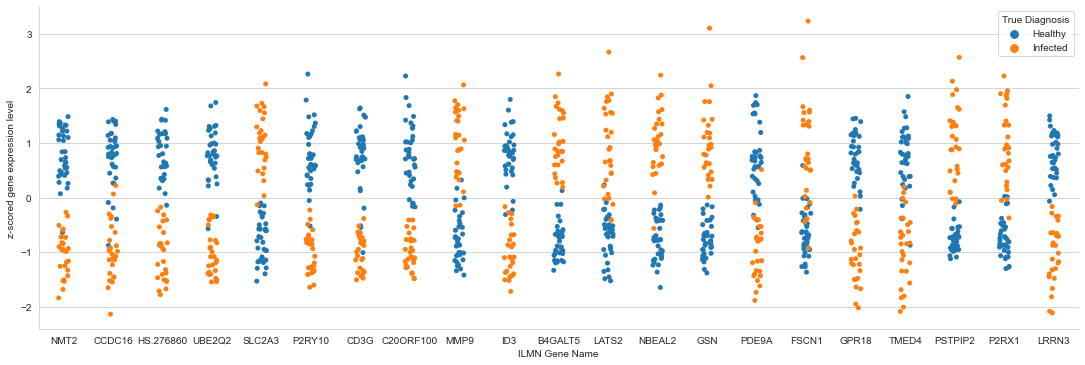

In [538]:
## create dataframe of selected genes based on index

selected_gene_df = gene_df.iloc[selected_index,]

## run function to generate zscores dataframe and plot
selected_gene_zscores_lr = selected_gene_zscores(selected_gene_df, X_df_no75, labels_no75)

sns.set_style("whitegrid")
lr_gene_plot = sns.catplot(data=selected_gene_zscores_lr,
                           x='variable',
                           y='value',
                           hue='Class',
                           kind='strip', 
                           height = 5,
                           aspect = 3,
                           legend=True,
                           legend_out=False,
                           )
lr_gene_plot.set(xlabel='ILMN Gene Name', ylabel='z-scored gene expression level')
lr_gene_plot._legend.set_title('True Diagnosis')
for t, l in zip(lr_gene_plot._legend.texts,("Healthy", "Infected")):
    t.set_text(l)

lr_gene_plot.savefig('edinb_gene_plot.png', dpi=400)

<AxesSubplot:>

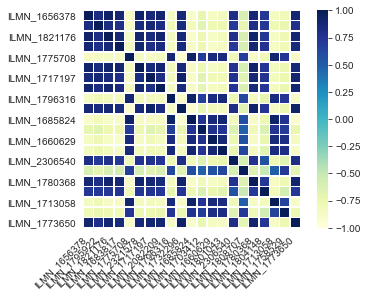

In [322]:
# Looking at the correlation of the selected genes based on expression levels in the dataset

data_selected = np.take(X_df_no75, selected_index, axis=1)

corr = data_selected.corr()
correlation_heatmap = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    linewidths=.5,
    cmap="YlGnBu",
    square=True
)
correlation_heatmap.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
correlation_heatmap

### Saving Model Results

In [278]:
# saving down results of the model:

with open('lr_results_new.pkl', 'wb') as f:
    pickle.dump([y_val_classes, y_val_predictions, features_index_list, selected_index, best_parameter], f)

with open('lr_results_new_final_model.pkl', 'wb') as f:
    pickle.dump([final_model], f)

In [373]:
# retriving saved results:

#with open('lr_results_new.pkl', 'rb') as f:
#    y_val_classes, y_val_predictions, features_index_list, selected_index, best_parameter = pickle.load(f)


# Testing on pearth RNASeq dataset

### Load Perth Data

In [529]:
## load noramalised and z-scored RNASeq data sets

p_norm_X = pd.read_csv('~/Documents/GitHub/sepsis_ml_omics_msc/dataset_pearth/an0304/ml_inputs/p_norm_X.csv', index_col=0)
p_vst_X = pd.read_csv('~/Documents/GitHub/sepsis_ml_omics_msc/dataset_pearth/an0304/ml_inputs/p_vst_X.csv', index_col=0)
p_fpkm_X = pd.read_csv('~/Documents/GitHub/sepsis_ml_omics_msc/dataset_pearth/an0304/ml_inputs/p_fpkm_X.csv', index_col=0)
p_labels = np.loadtxt('/Users/Ed/Documents/GitHub/sepsis_ml_omics_msc/dataset_pearth/an0304/ml_inputs/pearth_y.csv', delimiter=',')


### Create selected gene dataframe with mappings between platforms

In [429]:
# use selected index to reduce the gene dataframe to the selected genes, with codes that map across datasets
# need to make Probe_Id the index, so can use with the merged dataframe.

# read in merged gene codes data for illumina
gene_df_merged = pd.read_csv('gene_codes_merged.csv', index_col=0).set_index('Probe_Id')

# pull out the illumina Probe_Id to use as index filter
gene_index_ilmn = selected_gene_df['Probe_Id'].tolist()

p_missing_probe = 'ENSG00000283060'

# filter the gene dataframe on the selected genes
gene_signature_df = gene_df_merged.loc[gene_index_ilmn, :].dropna(axis=0, how='any')  # for now, remove nan values
gene_signature_df = gene_signature_df.reset_index(inplace=False).set_index('ensembl_gene_id')

# eliminate ensemble_IDs missing from pearth dataset

gene_signature_df = gene_signature_df.drop(p_missing_probe)
gene_signature_df = gene_signature_df.reset_index(inplace=False)
print(gene_signature_df)

gene_signature_ensembl = gene_signature_df['ensembl_gene_id'].tolist()
gene_signature_ilmn = gene_signature_df['Probe_Id'].tolist()
print(gene_signature_ilmn,gene_signature_ensembl)


    ensembl_gene_id      Probe_Id  ILMN_Gene external_gene_name
0   ENSG00000198783  ILMN_1795922     CCDC16             ZNF830
1   ENSG00000140367  ILMN_1683817     UBE2Q2             UBE2Q2
2   ENSG00000078589  ILMN_2321578     P2RY10             P2RY10
3   ENSG00000160654  ILMN_1717197       CD3G               CD3G
4   ENSG00000124191  ILMN_2082209  C20ORF100               TOX2
5   ENSG00000100985  ILMN_1796316       MMP9               MMP9
6   ENSG00000117318  ILMN_1732296        ID3                ID3
7   ENSG00000158470  ILMN_1685824    B4GALT5            B4GALT5
8   ENSG00000150457  ILMN_1703412      LATS2              LATS2
9   ENSG00000160796  ILMN_1660629     NBEAL2             NBEAL2
10  ENSG00000148180  ILMN_1801043        GSN                GSN
11  ENSG00000160191  ILMN_2306540      PDE9A              PDE9A
12  ENSG00000075618  ILMN_1808707      FSCN1              FSCN1
13  ENSG00000125245  ILMN_1780368      GPR18              GPR18
14  ENSG00000158604  ILMN_1804148      T

In [491]:
# create dictionaries of mapping between gene names to rename dataframes for analysis and visualisation

mapping_dict_il_en = gene_signature_df.set_index('Probe_Id')['ensembl_gene_id'].to_dict()
mapping_dict_en_geneName = gene_signature_df.set_index('ensembl_gene_id')['external_gene_name'].to_dict()

### Look at differential expression for selected genes in perth data

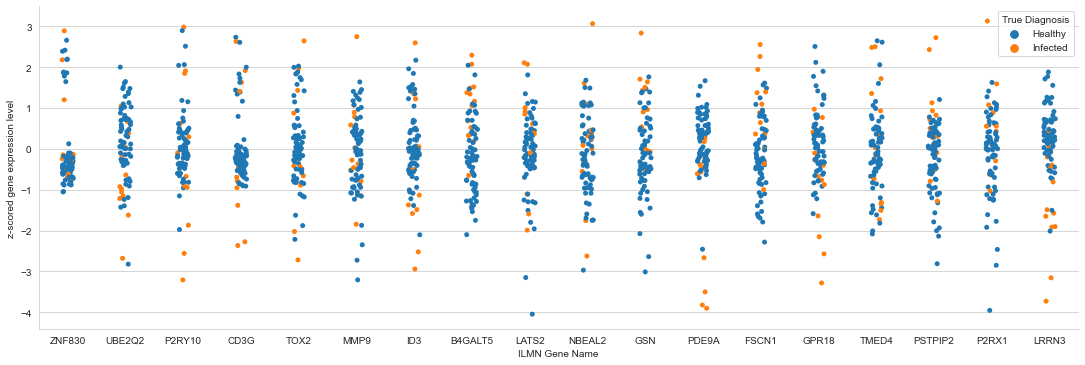

In [536]:
# looking at gene expression in the pearth dataset

def selected_gene_zscores_pearth(selected_gene_dataframe, dataset, labels):
    
    ''' pandas datafram --> pandas datafram
    Function takes a dataframe of the selected genes, with Probe_Id and ILMN_Gene
    and the input dataset of all z-scores across all 48,000 genes, and returns a melded
    dataframe of the selected genes and their Probe_ID names, with z-scores and true class'''
    
    gene_index_probe = selected_gene_dataframe['ensembl_gene_id'].tolist()
    gene_index_common = selected_gene_dataframe['external_gene_name'].tolist()
    gene_labels_dict = dict(zip(gene_index_probe, gene_index_common))
    selected_gene_zscores_df = dataset.loc[:, gene_index_probe]
    selected_gene_zscores_df['Class'] = labels
    selected_gene_zscores_df = selected_gene_zscores_df.rename(columns = gene_labels_dict)
    selected_gene_zscores_df = pd.melt(selected_gene_zscores_df, id_vars=['Class'],
                                                    value_vars=gene_index_common)
    return selected_gene_zscores_df


## run function to generate zscores dataframe and plot
selected_gene_zscores_pearth = selected_gene_zscores_pearth(gene_signature_df, p_vst_X, p_labels)

sns.set_style("whitegrid")
lr_gene_plot = sns.catplot(data=selected_gene_zscores_pearth,
                           x='variable',
                           y='value',
                           hue='Class',
                           kind='strip', 
                           height = 5,
                           aspect = 3,
                           legend=True,
                           legend_out=False,
                           )
lr_gene_plot.set(xlabel='ILMN Gene Name', ylabel='z-scored gene expression level')
lr_gene_plot._legend.set_title('True Diagnosis')
for t, l in zip(lr_gene_plot._legend.texts,("Healthy", "Infected")):
    t.set_text(l)

lr_gene_plot.savefig('perth_gene_plot.png', dpi=400)

### Create model training sets with selected features and common feature names

In [539]:
## prepare edinb dataset with ensembl gene IDs as feature names
X_train_edinb = X_df_no75.loc[:, gene_signature_ilmn]
X_train_edinb = X_train_edinb.rename(columns=mapping_dict_il_en)
print(X_train_edinb.shape)

(62, 18)


In [540]:
# create train matrix based on selected genes
X_train_pearth = p_vst_X.loc[:,gene_signature_ensembl]
print(X_train_pearth.shape)
print(labels_pearth.shape)

# check that column names match exactly
X_train_pearth.columns == X_train_edinb.columns

(78, 18)
(78,)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

### Train and test logistic regression model

In [541]:
## train a new logistic regression model, using selected features
model = LogisticRegression(C=best_parameter[0], penalty='none', solver="lbfgs")
model.fit(X_train_edinb, labels_no75)

/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


LogisticRegression(C=0.12856643083296349, penalty='none')

In [542]:
# make predictions on pearth data

y_predicted_probabilities = model.predict_proba(X_train_pearth)[:,1]


In [543]:
y_pred_classes, accuracy, recall, specificity, precision, auc = score_model(labels_pearth, y_predicted_probabilities,0.5)



In [546]:
print('auc:  '+str(auc))
print('sensitivity:  '+str(recall))
print('specificity:  '+str(specificity))

auc:  0.75
sensitivity:  0.69
specificity:  0.65


### Gene selection frequency in training rounds

In [277]:
# tally of gene selection frequencies in logistic regression training rounds
import operator

def gene_freq(features_index_list, n_listed):
    
    gene_frequency={}
    for ix_list in features_index_list:
        for ix in ix_list:
            if ix not in gene_frequency: gene_frequency[ix]=1
            else: gene_frequency[ix]+=1

    sorted_list = sorted(gene_frequency.items(), key=operator.itemgetter(1), reverse=True)
    bar_gene_names = []
    bar_gene_frequency = []
    for ix, frequency in sorted_list[:n_listed]:
        bar_gene_names.append(ix)
        bar_gene_frequency.append(frequency)
    bar_gene_names = gene_df.iloc[bar_gene_names, 1].tolist()
    bar_gene_freq_data = {'Gene': pd.Series(data=bar_gene_names),
                          'Frequency': pd.Series(data=bar_gene_frequency)}
    bar_gene_freq_df = pd.DataFrame(data=bar_gene_freq_data)
    return bar_gene_freq_df

bar_gene_freq_df = gene_freq(features_index_list, 20)
bar_gene_freq_df

,Gene,Frequency
0,UBE2Q2,62
1,ID3,62
2,HS.276860,61
3,P2RX1,61
4,NMT2,60
5,B4GALT5,59
6,GSN,58
7,LRRN3,56
8,NBEAL2,55
9,SLC2A3,53


### Reducing the number of features to smaller set
- Goal - use the features from LASSO to discover the minimal set
- Use RFE, or other sequential search over the remaining features to find small set

In [279]:
X_train = np.take(X_df_no75, selected_index, axis=1)
y_train = labels
X_train

,ILMN_1656378,ILMN_1795922,ILMN_1821176,ILMN_1683817,ILMN_1775708,ILMN_2321578,ILMN_1717197,ILMN_2082209,ILMN_1796316,ILMN_1732296,...,ILMN_1703412,ILMN_1660629,ILMN_1801043,ILMN_2306540,ILMN_1808707,ILMN_1780368,ILMN_1804148,ILMN_1713058,ILMN_1758529,ILMN_1773650
Con_001,1.370874,1.056878,1.614093,0.535055,-1.178336,1.172367,0.674261,1.049911,-1.308310,0.813338,...,-1.488621,-1.150826,-0.496556,0.346178,-0.015453,1.157559,1.004553,-0.887268,-1.301886,0.771386
Con_017,1.099632,1.026903,1.169858,0.959803,-1.088550,1.120675,0.918044,0.870512,-1.015675,0.853618,...,-0.712724,-1.032785,-0.915612,0.819292,-0.630995,0.639991,0.640210,-0.760280,-1.003785,0.448114
Con_021,0.456435,1.137899,0.652904,0.983147,-0.972075,0.584249,0.972777,0.202336,-0.754332,0.962225,...,-0.213277,-0.785229,-0.834481,1.867031,-0.686394,0.530927,0.236452,-0.820074,0.019714,0.752976
Con_022b,0.836831,0.775232,0.627705,0.685178,-1.158384,0.347639,0.164157,1.417201,-1.187304,1.334379,...,-0.569639,-0.732739,-1.048188,1.736880,-0.746765,0.637264,0.632451,-0.774476,-0.381294,0.974598
Con_028,1.127529,0.827466,1.028380,0.818979,-0.926798,1.161558,0.954063,1.367781,-0.424781,0.860908,...,-0.668449,-0.957957,-0.655215,0.564427,-0.113940,1.451228,1.269587,-0.571689,-1.120104,0.220009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Inf_162a,-0.825954,-0.638636,-1.510790,-0.339113,2.083386,-1.076721,-1.363941,-1.100283,1.771563,-1.398828,...,0.207338,0.969884,0.778481,-1.350144,1.338976,-1.500534,-0.989717,1.648290,0.811240,-1.451326
Inf_164,-0.901490,-1.549756,-0.873117,-1.481453,1.663446,-0.853974,-0.797092,-1.127764,1.398762,-0.856165,...,0.668989,1.823149,2.047609,-0.356423,0.130856,-0.462509,-1.806232,1.975226,0.597856,-0.700280
Inf_191,-1.507920,-0.986761,-1.521589,-1.411800,0.795000,-1.340352,-1.477331,-1.192518,1.703072,-1.449733,...,0.916282,2.240748,1.433003,-1.409600,1.305121,-1.640552,-1.057682,0.890660,0.609939,-1.819199
Inf_198,-0.980602,-1.143461,-0.842518,-1.541616,1.179725,-0.763512,-0.648085,-0.755992,1.596246,-1.089193,...,1.529657,0.588295,1.419890,-0.415154,-0.443255,-0.633001,-0.083202,1.301222,0.554568,-0.285644


In [289]:
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

rfe_n_features= []
rfe_n_score= []
rfe_n_index= []

# define pipeline and perform search
n_features_to_select = [10,9,8,7,6,5,4,3,2,1]
param_grid = {'n_features_to_select': n_features_to_select}

for param in ParameterGrid(param_grid):

    # fit model      
    cv_inner = LeaveOneOut()
    y_val_classes = []
    y_val_predictions = []
    for train_index, val_index in cv_inner.split(X_train):

        X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        y_train_inner, y_val = y_train[train_index], y_train[val_index]                

        # define the pipeline
        model = LogisticRegression(penalty='none', solver="lbfgs")
        rfe = RFE(estimator=model, n_features_to_select=20, step=1)
        rfe.set_params(**param)
        lr_pipeline = Pipeline(steps=[('rfe', rfe),
                                       ('model', model)])

        lr_pipeline.fit(X_train_inner, y_train_inner)

        y_val_pred = lr_pipeline.predict(X_val)
        y_val_classes.append(y_val)
        y_val_predictions.append(y_val_pred)
        index = lr_pipeline.named_steps['rfe'].support_
    score = roc_auc_score(y_val_classes, y_val_predictions)

    print('Parameters:'+str(param)+'  Score:'+str(score)+'  Index:'+str(index))
    rfe_n_features.append(param['n_features_to_select'])
    rfe_n_score.append(score)
    rfe_n_index.append(index)

rfe_n_features = np.asarray(rfe_n_features)  
rfe_n_score = np.asarray(rfe_n_score)  
rfe_n_index = np.asarray(rfe_n_index)
    
#cv_res = np.asarray(cv_res)    
#best_n_features = int(cv_res[np.argmax(cv_res[:,1])][0])


Parameters:{'n_features_to_select': 10}  Score:1.0  Index:[False  True False  True False False False  True False False  True  True
  True False  True  True False  True False  True False]
Parameters:{'n_features_to_select': 9}  Score:1.0  Index:[False  True False  True False False False  True False False  True  True
  True False False  True False  True False  True False]
Parameters:{'n_features_to_select': 8}  Score:1.0  Index:[False  True False  True False False False  True False False  True  True
 False False False  True False  True False  True False]
Parameters:{'n_features_to_select': 7}  Score:1.0  Index:[False False False  True False False False  True False False  True  True
 False False False  True False  True False  True False]
Parameters:{'n_features_to_select': 6}  Score:1.0  Index:[False False False  True False False False  True False False  True  True
 False False False  True False False False  True False]
Parameters:{'n_features_to_select': 5}  Score:1.0  Index:[False False

<AxesSubplot:xlabel='Features', ylabel='AUC'>

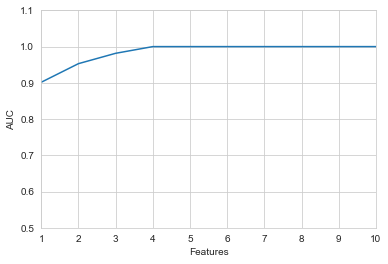

In [319]:

line_rfe_data = {'Features': pd.Series(data=rfe_n_features),
                          'AUC': pd.Series(data=rfe_n_score)}
line_rfe_data_df = pd.DataFrame(data=line_rfe_data)


auc_plot = sns.lineplot(x="Features", y="AUC",
             data=line_rfe_data_df)
auc_plot.set(xlim=(1, 10), ylim=(0.5, 1.1))
auc_plot

In [330]:
final_genes_index = np.where(rfe_n_index[6])[0]
final_genes = np.take(X_train, final_genes_index, axis=1)
final_genes_df = selected_gene_df[selected_gene_df['Probe_Id'].isin(final_genes.columns)]

# Not used

### Functions to extract genes from final models and plot them

In [118]:
# select features and match to common gene names for models that output coefficients

from matplotlib import pyplot

# identify genes where model outputs coefficients

def identify_genes_from_coefs(selected_features, dataset, gene_df):
    selected_gene_list = list(zip(dataset.columns, selected_features))

    selected_gene_codes = []
    selected_gene_coefficients = []
    for gene in selected_gene_list:
        if gene[1] != 0:
            selected_gene_codes.append(gene[0])
            selected_gene_coefficients.append(gene[1])

    # identify common gene codes
    selected_gene_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes)].iloc[:, np.r_[10, 1]]
    selected_gene_codes_common = list(selected_gene_df.iloc[:,1])

    # zip features importances with common names

    selected_gene_final = list(zip(selected_gene_codes_common, selected_gene_coefficients))
    selected_gene_final = sorted(selected_gene_final, key = lambda x: x[1])
    
    return selected_gene_final, selected_gene_df

# function to extract genes using feature importances data

def select_genes_fi(selected_features, dataset, gene_df):

    selected_gene_list = list(zip(dataset.columns, selected_features))

    selected_gene_codes = []
    selected_gene_coefficients = []
    for gene in selected_gene_list:
        if gene[1] > 0:
            selected_gene_codes.append(gene[0])
            selected_gene_coefficients.append(gene[1])

    # identify common gene codes
    selected_gene_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes)].iloc[:, np.r_[14, 5]]
    selected_gene_codes_common = list(selected_gene_df.iloc[:,1])

    # zip features importances with common names

    selected_gene_final = list(zip(selected_gene_codes_common, selected_gene_coefficients))
    selected_gene_final = sorted(selected_gene_final, key = lambda x: x[1])
    
    return selected_gene_final

# plot_of genes vs. coefficients

def plot_genes(features_sorted, model):
    pyplot.bar(range(len(features_sorted)), [val[1] for val in features_sorted])
    pyplot.xticks(range(len(features_sorted)), [val[0] for val in features_sorted])
    plt.title(model)
    pyplot.xticks(rotation=70)

### i. LR - Optimise for performance, regardless of number of features

In [766]:
# cross validation functions for logistic regression - no constraint on number of features.

def nested_cv_lr(df, labels, n_repeats):

    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []
    selected_features_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        model, best_parameter = train_lr_baysian(X_train, y_train)

        # predict on the test set and store the selected features
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)
        
        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        selected_features = model.coef_[0]

        # add scores for this train test split to lists collecting scores for all splits
        scores_list.append(scores)
        best_parameters_list.append(best_parameter)
        mis_classified_list.append(mis_classified)
        selected_features_list.append(selected_features)

    return scores_list, best_parameters_list, mis_classified_list, selected_features_list

def train_lr_baysian(X_train, y_train):
    # define cross validation approach
    cv_inner = LeaveOneOut()

    # define hyper paramaeter search space
    hyper_p_c = Real(low=1e-6, high=1000.0, prior='log-uniform', name='C')
    search_space_lr = [hyper_p_c]

    # define the objective function to optimise over the hyper-parameter search space. Here we want to minimise 1- the 
    # accuracy score - balancing recall and precision in the model.
    @use_named_args(search_space_lr)
    def evaluate_model(**params):
        cv_inner = LeaveOneOut()
        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]         
       
            # define the model
            model = LogisticRegression(penalty='l1', solver="liblinear")
            model.set_params(**params)
            model.fit(X_train_inner, y_train_inner)

            y_val_pred = model.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)
            
        score = accuracy_score(y_val_classes, y_val_predictions)
        return 1.0 - score

    # perform optimization
    result = gp_minimize(evaluate_model, search_space_lr, acq_func="EI", x0=[1.0], n_initial_points=20, n_calls=30)

    # save the best performing value of hyper parameter C
    best_parameter = result.x
    print('Best Parameters: %s' % (result.x))
    print('Best Score: %.3f' % (1.0 - result.fun))

    # retrain the model with fixed value of C
    model = LogisticRegression(C=best_parameter[0],
                                  penalty='l1',
                                  solver="liblinear")
    model.fit(X_train, y_train)

    return model, best_parameter

In [764]:
# run nested cross validation on test data set
scores_lr_red, best_parameters_lr_red, mis_classified_lr_red, selected_features_list_lr_red = nested_cv_lr(X_df_red, labels, 1)

# print results
print('The results for logistic regression test examples:')
print(scores_lr_red)
print(best_parameters_lr_red)
print(np.mean(np.asarray(scores_lr_red), axis=0))
print(mis_classified_lr_red)

Best Parameters: [1.0]
Best Score: 0.976
Best Parameters: [678.4237085411913]
Best Score: 0.905
Best Parameters: [1.0]
Best Score: 0.929
The results for logistic regression test examples:
[(0.95, 0.91, 1.0, 1.0, 0.98), (0.95, 1.0, 0.92, 0.89, 0.99), (0.86, 0.89, 0.83, 0.8, 0.98)]
[[1.0], [678.4237085411913], [1.0]]
[0.92       0.93333333 0.91666667 0.89666667 0.98333333]
[{'Inf075': 'fn'}, {'Con_165a': 'fp'}, {'Con_087a': 'fp', 'Con_096a': 'fp', 'Inf_119': 'fn'}]


Best Parameters: [1.0]
Best Score: 0.976
Best Parameters: [0.08228844256425769]
Best Score: 1.000
Best Parameters: [34.879632734662266]
Best Score: 0.952
Best Parameters: [1.0]
Best Score: 1.000
Best Parameters: [1.2789088991773574]
Best Score: 1.000
Best Parameters: [5.478667394027816]
Best Score: 0.976
Best Parameters: [0.09070443334341415]
Best Score: 0.952
Best Parameters: [12.164923684430583]
Best Score: 0.976
Best Parameters: [1.0]
Best Score: 1.000


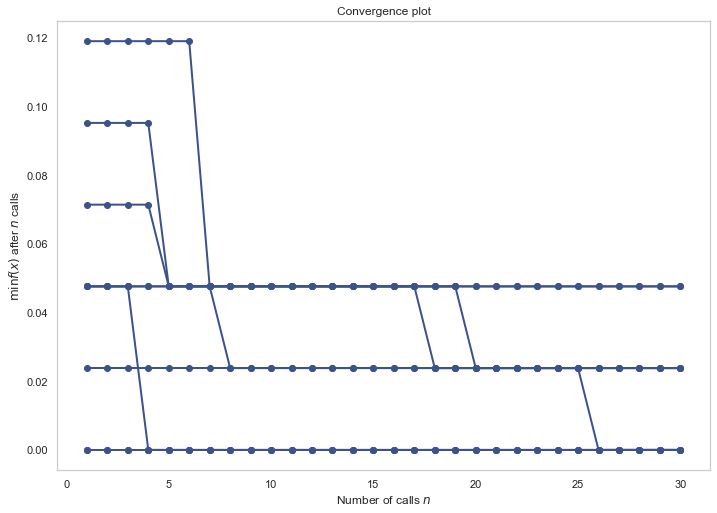

In [381]:
# run optimisations on full dataset (including patient 75)

scores_lr, best_parameters_lr, mis_classified_lr, selected_features_list_lr = nested_cv_lr(X_df,  labels, 3)

In [399]:
# create datafrom from the results - including the number of selected features each iteration

def lr_results_df_inc_features(scores, parameters, misclassified, features):
    p_list = []
    for i in parameters:
        p_list.extend(i)
    p_list = np.array(p_list)
    p_list = np.around(p_list, decimals=2)
    p_list = np.append(p_list, ['n/a'], axis=0)
    mean_scores = np.mean(np.asarray(scores), axis=0)
    array = np.array(scores)
    array = np.vstack((array, mean_scores))
    array = pd.DataFrame(array, index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 'Mean'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])
    # FOR TESTING array = pd.DataFrame(array, index = [1, 2, 3, 'Mean'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])

    array = array.round(2)
    array.insert(0, 'Best C', p_list)

    # create column for the number of features
    feat_count_list = []
    for i in features:
        feat_count = np.count_nonzero(i)
        feat_count_list.append(feat_count)
    feat_count_list = np.append(feat_count_list, [str(round(np.mean(feat_count_list),0))], axis=0)
    feat_count_list = np.array(feat_count_list)
    array.insert(1, 'Num Features', feat_count_list)
    
    # create columns for false positives and false negatives
    fp_column = []
    fn_column = []
    for i in misclassified:
        fps = []
        fns = []
        for key, val in i.items():
            if val == 'fp':
                fps.append(key)
            if val == 'fn':
                fns.append(key)
        fp_column.append(fps)
        fn_column.append(fns)
    fp_column.append('n/a')
    fn_column.append('n/a')
    array.insert(7, 'False Positives', fp_column)
    array.insert(8, 'False Negatives', fn_column) 
    
    return array

In [291]:
lr_results_testing = lr_results_df_inc_features(scores_lr_red, best_parameters_lr_red, mis_classified_lr_red, selected_features_list_lr_red)
lr_results_testing

,Best C,Num Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,289.38,30,0.90,1.00,0.82,0.83,0.96,"[Con_165a, Con_181a]",[]
2,0.24,4,0.95,0.90,1.00,1.00,1.00,[],[Inf_149]
3,122.0,30,0.95,0.88,1.00,1.00,0.96,[],[Inf075]
Total,n/a,n/a,0.93,0.93,0.94,0.94,0.97,n/a,n/a


In [400]:
# create dataframe of results including patient 75
lr_results_df_all_inc75 = lr_results_df_inc_features(scores_lr, best_parameters_lr, mis_classified_lr, selected_features_list_lr)
lr_results_df_all_inc75 = lr_results_df_all_inc75.drop(['False Positives', 'False Negatives'], axis=1) 
lr_results_df_all_inc75

,Best C,Num Features,Accuracy,Recall,Specificity,Precision,AUC
1,1.0,101,0.95,0.88,1.00,1.00,0.98
2,0.08,2,0.90,1.00,0.82,0.83,0.98
3,34.88,210,0.95,1.00,0.91,0.91,1.00
4,1.0,68,0.81,1.00,0.67,0.69,0.91
5,1.28,91,0.95,0.89,1.00,1.00,0.95
6,5.48,139,1.00,1.00,1.00,1.00,1.00
7,0.09,4,0.90,1.00,0.78,0.86,1.00
8,12.16,177,1.00,1.00,1.00,1.00,1.00
9,1.0,64,0.90,0.90,0.91,0.90,0.98
Mean,n/a,95.0,0.93,0.96,0.90,0.91,0.98


In [393]:
# produce the LaTex code:

with open('lr_results_table_all_inc75.tex','w') as tf:
    tf.write(lr_results_df_all_inc75.to_latex())


Best Parameters: [1.0]
Best Score: 0.968


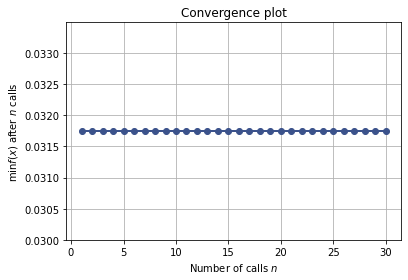

In [354]:
# train final model and determine features

final_lr, best_param = train_lr_baysian(X_df, labels)

In [391]:
# select features and match to common gene names

selected_features_lr = final_lr.coef_[0]
selected_gene_lr_final, selected_gene_lr_df = identify_genes_from_coefs(selected_features_lr, X_df, gene_df)


In [392]:
print('The number of selected genes is:  '+str(len(selected_gene_lr_final)))
#plot_genes(selected_gene_lr_final, model='logistic regression')

The number of selected genes is:  336


In [705]:
# saving down results of the model

with open('lr_results.pkl', 'wb') as f:
    pickle.dump([scores_lr, best_parameters_lr, mis_classified_lr, selected_features_list_lr], f)

In [92]:
#with open('lr_results.pkl', 'rb') as f:
#    scores_lr, best_parameters_lr, mis_classified_lr, selected_features_lr = pickle.load(f)

In [971]:
with open('lr_final_model.pkl', 'wb') as f:
    pickle.dump([final_lr, best_param], f)

In [390]:
with open('lr_final_model.pkl', 'rb') as f:
    final_lr, best_param = pickle.load(f)

In [490]:
# putting results into a dataframe
lr_results_frames = [lr_df_30f,lr_df_25f,lr_df_20f,lr_df_15f,lr_df_10f,lr_df_9f,lr_df_8f,lr_df_7f,lr_df_6f,lr_df_5f,lr_df_4f,lr_df_3f]

lr_aucs =[]
lr_avg_feat=[]
lr_mm_range = []
for df in lr_results_frames:
    lr_aucs.append(df['AUC'].values[-1])
    lr_avg_feat.append(df['Num Features'].values[-1])
data = np.vstack((lr_aucs, lr_avg_feat))
data = np.transpose(data)
lr_perf_features = pd.DataFrame(data=data, index=[30,25,20,15,10,9,8,7,6,5,4,3], columns=['AUC', 'Mean Features'])
lr_perf_features

,AUC,Mean Features
30,1.0,27.0
25,0.99,22.0
20,1.0,18.0
15,1.0,15.0
10,1.0,9.0
9,1.0,10.0
8,0.99,9.0
7,0.88,5.0
6,0.99,6.0
5,0.93,4.0


### Code Sources:

- Feature selection: https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/
- Nested cross validation: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
- LOOCV: https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/
- scikit-opt: https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
- Baysian opt: https://towardsdatascience.com/optimizing-hyperparameters-the-right-way-3c9cafc279cc
- scikit-opt gp_minimize: https://scikit-optimize.github.io/stable/modules/generated/skopt.optimizer.gp_minimize.html#skopt.optimizer.gp_minimize
